In [1]:
import pandas as pd

# Mengimpor dataset
file_path = '/workspaces/codespaces-jupyter/data/processed/harga_sayuran_clean.csv'
data = pd.read_csv(file_path)

# Menampilkan beberapa baris pertama dari dataset
data.head()


,ID,Jenis Sayuran,Tanggal Harga,Season,Harga Beli Pengepul per Kilogram,Harga Beli Pasar per Kilogram,Harga Jual Pasar per Kilogram
0,1,Sawi Putih,1/1/2021,Hujan,3452.271603,3752.737482,4972.799167
1,2,Cabe Chilli,1/1/2021,Hujan,20762.943610,24271.626950,29673.381620
2,3,Cabe Kriting,1/1/2021,Hujan,34203.878890,38963.481980,49057.978400
3,4,Cabe Rawit,1/1/2021,Hujan,52807.009800,56674.717880,69292.070200
4,5,Kol,1/1/2021,Hujan,1769.608362,2044.366134,2642.944919


#### Statistik Deskriptif

In [2]:
data.describe()


,ID,Harga Beli Pengepul per Kilogram,Harga Beli Pasar per Kilogram,Harga Jual Pasar per Kilogram
count,6570.000000,6570.000000,6570.000000,6570.000000
mean,3285.500000,17879.637092,19852.877240,24811.288887
std,1896.739966,16711.267606,18543.764025,23150.543396
min,1.000000,390.000808,442.661467,579.244052
25%,1643.250000,3789.712245,4223.733994,5312.589179
50%,3285.500000,11446.808715,12705.961055,15786.239180
75%,4927.750000,29114.756605,32333.431187,40450.001362
max,6570.000000,90092.030730,97922.745150,116228.072400


#### Missing Values

In [3]:
data.isnull().sum()


ID                                  0
Jenis Sayuran                       0
Tanggal Harga                       0
Season                              0
Harga Beli Pengepul per Kilogram    0
Harga Beli Pasar per Kilogram       0
Harga Jual Pasar per Kilogram       0
dtype: int64

#### Visualisasi Data

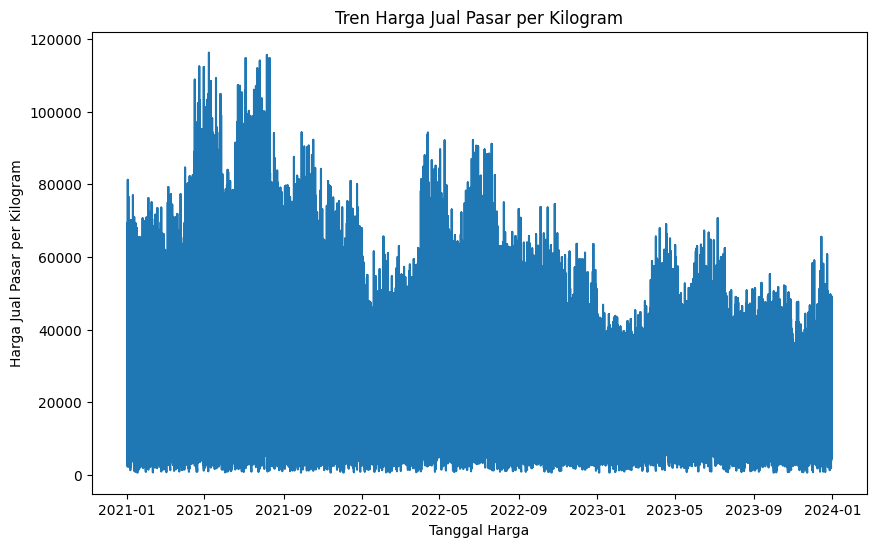

In [5]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot the 'Harga Jual Pasar per Kilogram' column over time
plt.plot(data['Tanggal Harga'], data['Harga Jual Pasar per Kilogram'])

# Set the x-axis label
plt.xlabel('Tanggal Harga')

# Set the y-axis label
plt.ylabel('Harga Jual Pasar per Kilogram')

# Set the title
plt.title('Tren Harga Jual Pasar per Kilogram')

# Show the plot
plt.show()

In [4]:
import matplotlib.pyplot as plt

# Mengonversi kolom 'Tanggal Harga' menjadi datetime
data['Tanggal Harga'] = pd.to_datetime(data['Tanggal Harga'])

# Visualisasi Harga Sayuran per KG
plt.figure(figsize=(10, 6))
for sayuran in data['Jenis Sayuran'].unique():
    subset = data[data['Jenis Sayuran'] == sayuran]
    plt.plot(subset['Tanggal Harga'], subset['Harga Sayuran per KG'], label=sayuran)

plt.legend()
plt.xlabel('Tanggal')
plt.ylabel('Harga Sayuran per KG')
plt.title('Tren Harga Sayuran per KG')
plt.show()


KeyError: 'Harga Sayuran per KG'

<Figure size 1000x600 with 0 Axes>

### Data Preparation

#### Training & Testing

In [6]:
from sklearn.model_selection import train_test_split

# Mengonversi kolom 'Musim' menjadi numerik menggunakan one-hot encoding
data_encoded = pd.get_dummies(data, columns=['Musim'])

# Memilih fitur dan target
features = ['Harga Sayuran per KG', 'Harga Pasar'] + list(data_encoded.columns[5:])
target = 'Harga Cabai Normalized'

X = data_encoded[features]
y = data_encoded[target]

# Membagi data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((6132, 5), (1533, 5), (6132,), (1533,))

## SVR

In [8]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Melatih model SVR
model_svr = SVR(kernel='rbf')
model_svr.fit(X_train, y_train)

# Membuat prediksi
predictions_svr = model_svr.predict(X_test)

# Evaluasi model
mse_svr = mean_squared_error(y_test, predictions_svr)

mse_svr, predictions_svr[:5]


(195601317.8990135,
 array([4626.43574636, 4984.21104428, 4592.883059  , 4562.48904084,
        5837.50337063]))

## Random Forest

In [9]:
from sklearn.ensemble import RandomForestRegressor

# Melatih model Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Membuat prediksi
predictions_rf = model_rf.predict(X_test)

# Evaluasi model
mse_rf = mean_squared_error(y_test, predictions_rf)

mse_rf, predictions_rf[:5]


(1492.4371293909674,
 array([ 6598.036 ,  2617.63  ,  4526.75  ,  1908.77  , 45364.1185]))

## ARIMA

In [10]:
!pip install pmdarima

import pmdarima as pm
from sklearn.metrics import mean_squared_error

# Menggunakan kolom 'Tanggal Harga' sebagai indeks
data.set_index('Tanggal Harga', inplace=True)

# Mengambil salah satu jenis sayuran sebagai contoh
sayuran_data = data[data['Jenis Sayuran'] == 'Cabe Chilli']['Harga Sayuran per KG']

# Membagi data menjadi training dan testing set
train = sayuran_data[:int(0.8*(len(sayuran_data)))]
test = sayuran_data[int(0.8*(len(sayuran_data))):]

# Melatih model ARIMA
model_arima = pm.auto_arima(train, seasonal=False, stepwise=True)

# Membuat prediksi
predictions_arima = model_arima.predict(n_periods=len(test))

# Evaluasi model
mse_arima = mean_squared_error(test, predictions_arima)

mse_arima, predictions_arima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 48.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 30.3 MB/s eta 0:00:0000:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 6.3 MB/s eta 0:00:00ta 0:00:01

[notice] A new release of pip is available: 23.3.1 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip


(336498337.09086573,
 2023-05-27    48328.179073
 2023-05-28    48919.121989
 2023-05-29    48958.896538
 2023-05-30    48808.339782
 2023-05-31    48727.499151
                   ...     
 2023-12-27    39086.403155
 2023-12-28    39040.527073
 2023-12-29    38994.650992
 2023-12-30    38948.774910
 2023-12-31    38902.898828
 Freq: D, Length: 219, dtype: float64)

## Modeling

In [14]:
pip install flask


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.3/227.3 kB 7.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
import pickle

# Menyimpan model Random Forest
with open('/workspaces/codespaces-jupyter/models/model_rf.pkl', 'wb') as f:
    pickle.dump(model_rf, f)


In [22]:
import pickle

# Simpan X_test ke dalam file
with open('/workspaces/codespaces-jupyter/models/X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)
